In [1]:
import scanpy as sc
import scipy
import numpy as np
import pandas as pd
import anndata as an
import matplotlib.pyplot as plt
import sklearn
import pickle 
import dataframe_image as dfi
import tangram as tg
import tangram_add_ons as tgx
import seaborn as sns

sc.logging.print_header()
import squidpy as sq
print(f"squidpy=={sq.__version__}")

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/merle/anaconda3/envs/tangram-env/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


scanpy==1.9.8 anndata==0.9.2 umap==0.5.5 numpy==1.24.3 scipy==1.10.0 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.4 louvain==0.8.2 pynndescent==0.5.11
squidpy==1.2.3


# Dataset dependencies

Load Visium & single cell mouse cortex dataset

In [ ]:
adata_st = sq.datasets.visium_fluo_adata_crop()
adata_st = adata_st[
    adata_st.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])
].copy()

In [3]:
adata_sc = sq.datasets.sc_mouse_cortex()

### Preprocess

In [4]:
qc_1 = pd.read_csv("visium_mouse_cortex_cells_qc1.csv",index_col=0)
adata_sc.var["gene_counts"] = qc_1["total_counts"]
adata_sc.var["n_cells"] = qc_1["n_cells_by_counts"]

In [5]:
qc_1 = pd.read_csv("visium_mouse_cortex_voxels_qc1.csv",index_col=0)
adata_st.var["gene_counts"] = qc_1["total_counts"]
adata_st.var["n_voxels"] = qc_1["n_cells_by_counts"]

In [6]:
tg.pp_adatas(adata_sc, adata_st)

INFO:root:14785 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:14785 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


sort overlapping genes 2


In [ ]:
adata_sc_overlap = adata_sc[:,adata_sc.uns["overlap_genes"]].copy()

In [8]:
qc_0 = pd.read_csv("visium_mouse_cortex_cells_qc0.csv",index_col=0)
adata_sc_overlap.obs["gene_counts"] = qc_0["total_counts"]
adata_sc_overlap.obs["n_genes"] = qc_0["n_genes_by_counts"]

In [ ]:
adata_st_overlap = adata_st[:,adata_st.uns["overlap_genes"]].copy()

In [10]:
qc_0 = pd.read_csv("visium_mouse_cortex_voxels_qc0.csv",index_col=0)
adata_st_overlap.obs["gene_counts"] = qc_0["total_counts"]
adata_st_overlap.obs["n_genes"] = qc_0["n_genes_by_counts"]

In [ ]:
with open('benchmarking/visium_mouse_cortex_modifications_detailed_test.pkl', 'rb') as f:
    metrics_test = pickle.load(f)
with open('benchmarking/visium_mouse_cortex_modifications_detailed_train.pkl', 'rb') as f:
    metrics_train = pickle.load(f)
with open('benchmarking/visium_mouse_cortex_modifications_detailed_all.pkl', 'rb') as f:
    metrics_all = pickle.load(f)

### Cells

In [48]:
adata_sc_overlap.obs["cell_map_corr"] = metrics_all["c_cell_map_corr"]["orig_allgenes"]
adata_sc_overlap.obs["cell_map_vote_entropy"] = 1 - np.array(metrics_all["cell_map_vote_entropy"]["orig_allgenes"])
adata_sc_overlap.obs["cell_map_consensus_entropy"] =1- np.array(metrics_all["cell_map_consensus_entropy"]["orig_allgenes"])

In [49]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
custom_cmap0 = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "tab:green"])
custom_cmap1 = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "tab:orange"])

In [ ]:
metric_labels = {
    "n_genes" : "# Genes",
    "gene_counts" : "Read counts", 
    'cell_map_corr' : "Cell mapping\nconsistency",
    'cell_map_vote_entropy' : "Cell mapping\nagreement",
    'cell_map_consensus_entropy' : 'Cell mapping\ncertainty',
}
metric_color = {
    "n_genes" : "#0065bd",
    "gene_counts" : "#0065bd", 
    'cell_map_corr' :"orange",#"tab:green",
    'cell_map_vote_entropy' : "xkcd:pumpkin orange",#"tab:orange",
    'cell_map_consensus_entropy' : "orangered",#'tab:orange',
}

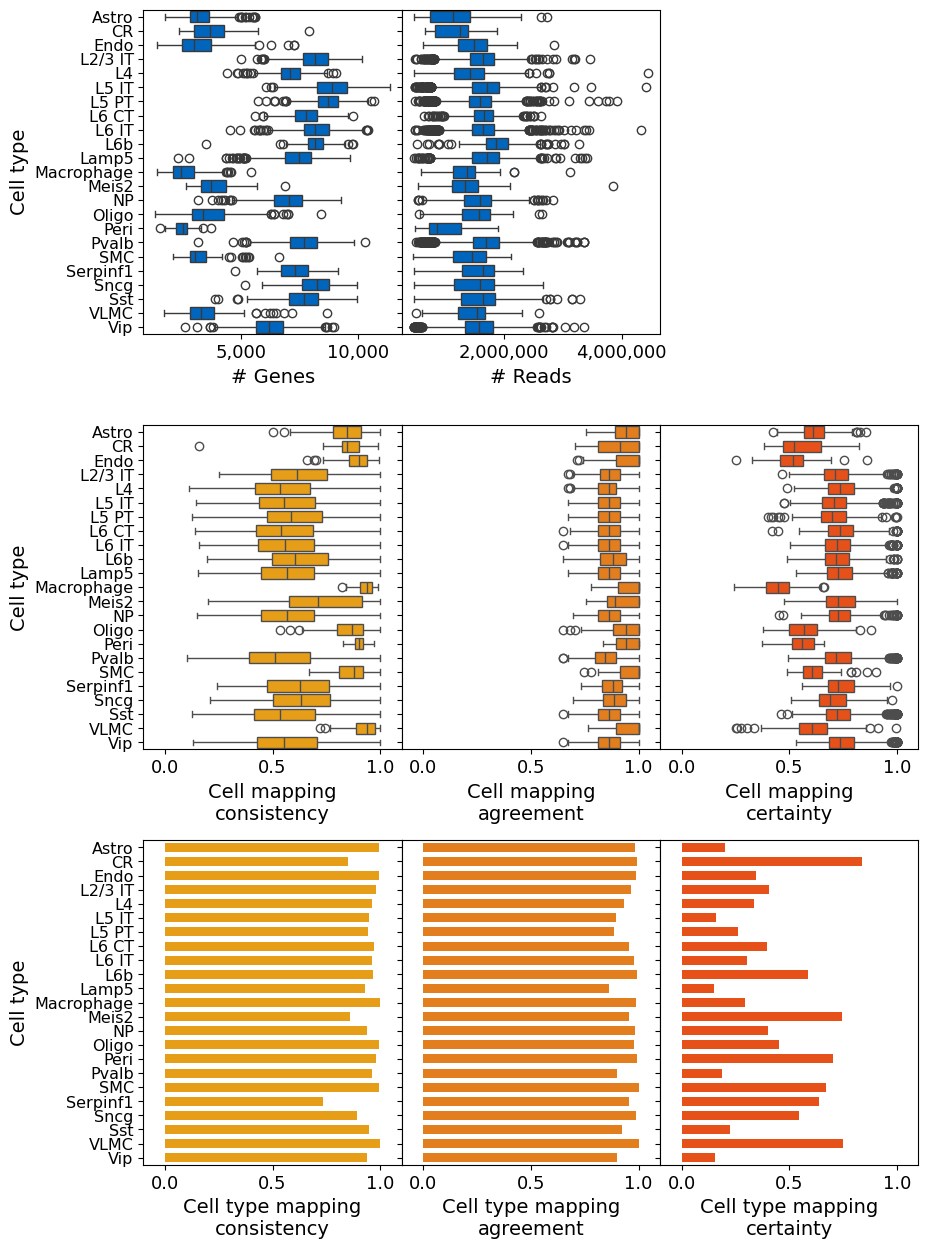

In [ ]:
df = adata_sc_overlap.obs


fig, axes = plt.subplots(3, 3, figsize=(10,15), sharey=True)

metric_names = [
    'cell_map_corr',
    'cell_map_vote_entropy', 
    'cell_map_consensus_entropy',
]

for i in range(len(metric_names)):
    m = metric_names[i]
    sns.boxplot(df, x=m, y="cell_subclass", ax=axes[1][i], color=metric_color[m], saturation=0.8, legend=False,)# palette={label: color for label,color in zip(labels,colors)})
    axes[1][i].set_xlabel(metric_labels[m], fontsize=14)
    axes[1][i].set_ylabel("Cell type", fontsize=14)
    axes[1][i].set(xlim=(-0.1, 1.1))

metric_names = [
    "n_genes",
    "gene_counts"
]

df = adata_sc_overlap.obs
for i in range(2):
    m = metric_names[i]
    sns.boxplot(df, x=m, y="cell_subclass", ax=axes[0][i], color=metric_color[m], saturation=1, legend=False,)# palette={label: color for label,color in zip(labels,colors)})
    axes[0][i].set_xlabel(metric_labels[m], fontsize=14)
    axes[0][i].set_ylabel("Cell type", fontsize=14)
    axes[0][i].get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    if i > 1:
        axes[0][i].set(xlim=(-0.1, 1.1))
df = pd.DataFrame({"cell_subclass" : adata_st.obsm["tangram_ct_pred"].columns,#np.unique(adata_sc.obs["cell_subclass"]), 
                    "ct_map_corr" : metrics_all["c_ct_map_corr"]["orig_allgenes"],
                    "ct_map_vote_entropy" : 1-np.array(metrics_all["ct_map_vote_entropy"]["orig_allgenes"]).mean(axis=1),
                    "ct_map_consensus_entropy" : 1-np.array(metrics_all["ct_map_consensus_entropy"]["orig_allgenes"]).mean(axis=1)})
metric_names = [
    "ct_map_corr",
    'ct_map_vote_entropy',
    'ct_map_consensus_entropy'
]
for i in range(len(metric_names)):
    m = metric_names[i]
    sns.barplot(df, x=m, y="cell_subclass", ax=axes[2][i], legend=False,
                gap=0.2,
                color=metric_color[m], saturation=0.8,
                )
    axes[2][i].set_xlabel(metric_labels[m], fontsize=14)
    axes[2][i].set_ylabel("Cell type", fontsize=14)
    axes[2][i].set(xlim=(-0.1, 1.1))
axes[0, 2].axis('off')
for i in range(3):
    for j in range(3):
        axes[i][j].tick_params(axis='x', which='major', labelsize=13)
        axes[i][j].tick_params(axis='y', which='major', labelsize=11.5)
plt.subplots_adjust(wspace=0, hspace=0.28)
plt.show()

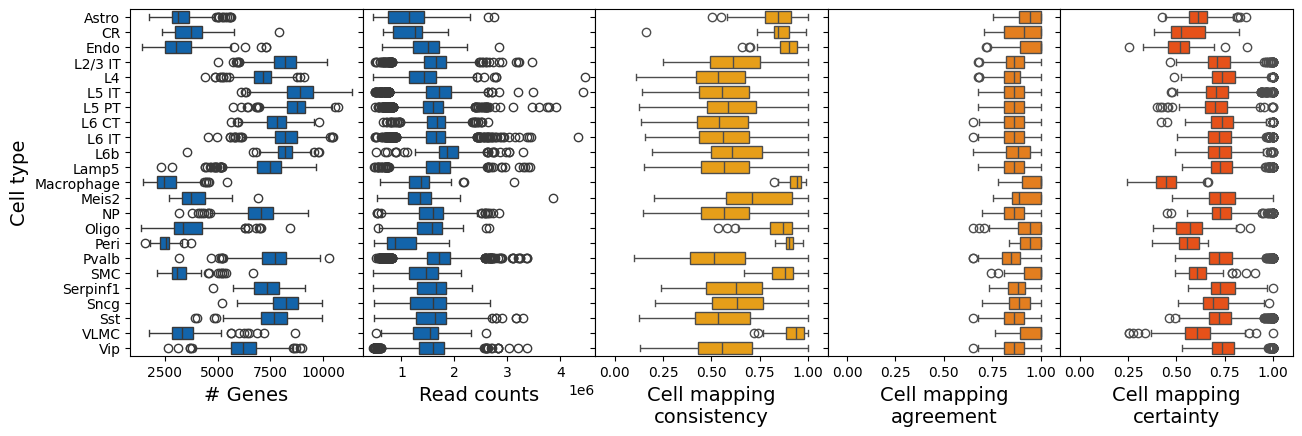

In [ ]:
metric_names = [
    "n_genes",
    "gene_counts",
    'cell_map_corr',
    'cell_map_vote_entropy', 
    'cell_map_consensus_entropy',
]
df = adata_sc_overlap.obs

fig, axes = plt.subplots(1, len(metric_names), figsize=(3*len(metric_names),4.5), sharey=True)
for i in range(len(metric_names)):
    m = metric_names[i]
    sns.boxplot(df, x=m, y="cell_subclass", ax=axes[i], color=metric_color[m], saturation=0.8, legend=False,)# palette={label: color for label,color in zip(labels,colors)})
    axes[i].set_xlabel(metric_labels[m], fontsize=14)
    axes[i].set_ylabel("Cell type", fontsize=14)
    if i > 1:
        axes[i].set(xlim=(-0.1, 1.1))
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Spots

In [53]:
adata_st_overlap.obs["gene_corr"] = metrics_all["v_gene_expr_corr"]["orig_allgenes"]
adata_st_overlap.obs["gene_cosine_sim"] = np.array(metrics_all["v_gene_expr_cosine_sim"]['orig_allgenes']).mean(axis=0)

adata_st_overlap.obs["cell_map_corr"] = metrics_all["v_cell_map_corr"]["orig_allgenes"]
adata_st_overlap.obs["cell_map_vote_entropy"] = 1 - np.array(metrics_all["cell_map_voxel_vote_entropy"]["orig_allgenes"])
adata_st_overlap.obs["cell_map_consensus_entropy"] = 1 - np.array(metrics_all["cell_map_voxel_consensus_entropy"]["orig_allgenes"])

adata_st_overlap.obs["ct_map_corr"] = metrics_all["v_ct_map_corr"]["orig_allgenes"]
adata_st_overlap.obs["ct_map_vote_entropy"] = 1 - np.array(metrics_all["ct_map_vote_entropy"]["orig_allgenes"]).mean(axis=0)
adata_st_overlap.obs["ct_map_consensus_entropy"] = 1 - np.array(metrics_all["ct_map_consensus_entropy"]["orig_allgenes"]).mean(axis=0)

In [55]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
custom_cmap0 = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "tab:green"])
custom_cmap1 = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "tab:orange"])

In [56]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

#sns.light_palette("#0065bd", reverse=False, as_cmap=True)
custom_cmapB = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "#0065bd"])
custom_cmap0 = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "tab:green"])
custom_cmap1 = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "tab:green"])
custom_cmap2 = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "orange"])
custom_cmap3 = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "xkcd:pumpkin orange"])
custom_cmap4 = mcolors.LinearSegmentedColormap.from_list("custom_palette", ["white", "orangered"]) #"xkcd:bright orange"

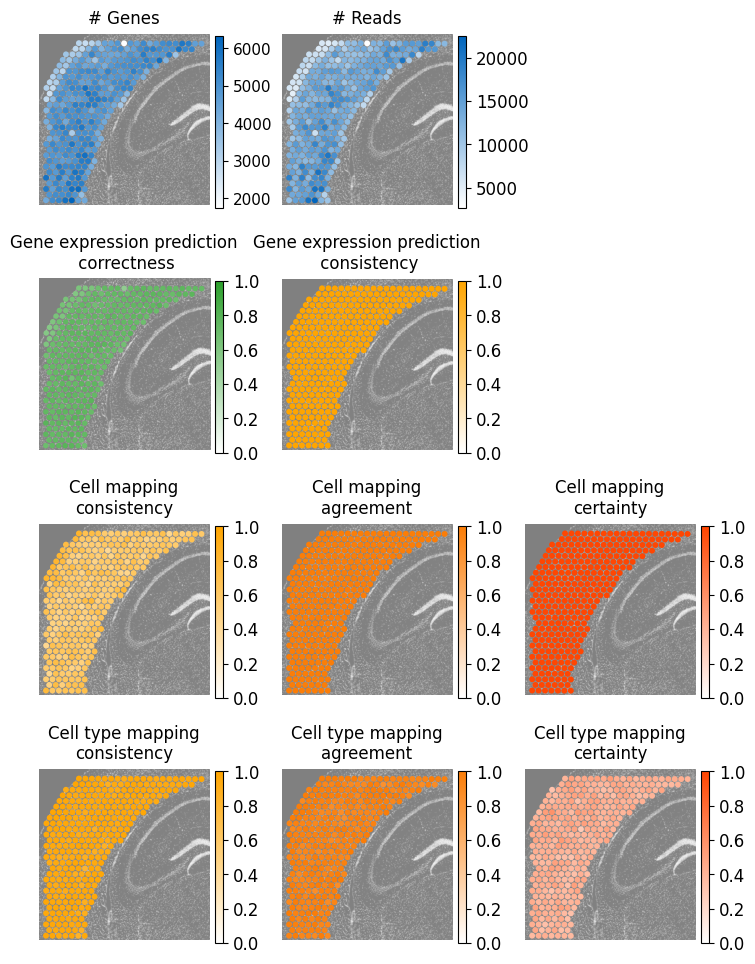

In [ ]:
# VOXELS
import matplotlib as mpl

fig, axs = plt.subplots(4, 3, figsize=(9,12))

sc.pl.spatial(
    adata_st_overlap, legend_loc=None, color="n_genes", title="# Genes", size=1.4, 
    frameon=False, ax=axs[0][0],alpha_img=0.5, bw=True, show=False,cmap=custom_cmapB,colorbar_loc=None
)
sc.pl.spatial(
    adata_st_overlap, color="gene_counts", title="# Reads", size=1.4,
    frameon=False,  ax=axs[0][1],show=False, alpha_img=0.5, bw=True,cmap=custom_cmapB,colorbar_loc=None
)
sc.pl.spatial(
    adata_st_overlap, legend_loc=None, color="gene_cosine_sim", title="Gene expression prediction\n correctness", size=1.3,
    frameon=False,alpha_img=0.5, bw=True,show=False, ax=axs[1][0],
    norm = mpl.colors.Normalize(vmin=0, vmax=1,), cmap=custom_cmap1,colorbar_loc=None
)
sc.pl.spatial(
    adata_st_overlap, color="gene_corr", title="Gene expression prediction\n consistency", size=1.4, 
    frameon=False,alpha_img=0.5, bw=True,show=False, ax=axs[1][1],
    norm = mpl.colors.Normalize(vmin=0, vmax=1,),cmap=custom_cmap2,colorbar_loc=None
)
sc.pl.spatial(
    adata_st_overlap, legend_loc=None, color="cell_map_corr", title="Cell mapping\nconsistency", 
      size=1.4,
    frameon=False,alpha_img=0.5, bw=True,show=False, ax=axs[2][0],
    norm = mpl.colors.Normalize(vmin=0, vmax=1,),cmap=custom_cmap2,colorbar_loc=None
)
sc.pl.spatial(
    adata_st_overlap, color="cell_map_vote_entropy", title="Cell mapping\nagreement", 
    size=1.4,
      frameon=False,alpha_img=0.5, bw=True,show=False, ax=axs[2][1],norm = mpl.colors.Normalize(vmin=0, vmax=1,),
      color_map=custom_cmap3,colorbar_loc=None
)
sc.pl.spatial(
    adata_st_overlap, legend_loc=None, color="cell_map_consensus_entropy", title="Cell mapping\ncertainty", 
    size=1.4,
    frameon=False,alpha_img=0.5, bw=True,show=False, ax=axs[2][2],norm = mpl.colors.Normalize(vmin=0, vmax=1,),
    color_map=custom_cmap4,colorbar_loc=None
)
sc.pl.spatial(
    adata_st_overlap, legend_loc=None, color="ct_map_corr", title="Cell type mapping\nconsistency", 
      size=1.4,
    frameon=False,alpha_img=0.5, bw=True,show=False, ax=axs[3][0],
    norm = mpl.colors.Normalize(vmin=0, vmax=1,),cmap=custom_cmap2,colorbar_loc=None
)
sc.pl.spatial(
    adata_st_overlap, color="ct_map_vote_entropy", title="Cell type mapping\nagreement", 
    size=1.4,
      frameon=False,alpha_img=0.5, bw=True,show=False, ax=axs[3][1],norm = mpl.colors.Normalize(vmin=0, vmax=1,),
      color_map=custom_cmap3,colorbar_loc=None
)
axs[3][2].tick_params(labelsize=20)
sc.pl.spatial(
    adata_st_overlap, legend_loc=None, color="ct_map_consensus_entropy", 
    title="Cell type mapping\ncertainty", 
    size=1.4,
    frameon=False,alpha_img=0.5, bw=True,show=False, ax=axs[3][2],
    norm = mpl.colors.Normalize(vmin=0, vmax=1,),
    color_map=custom_cmap4,
    colorbar_loc=None
)
adata_st_overlap.obs["n_genes"]
adata_st_overlap.obs["gene_counts"]
norm = mpl.colors.Normalize(vmin=adata_st_overlap.obs["n_genes"].min(), vmax=adata_st_overlap.obs["n_genes"].max())
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=custom_cmapB),ax=axs[0][0],
                            pad=0.01,shrink=0.91)
cbar.ax.tick_params(labelsize=11)
norm = mpl.colors.Normalize(vmin=adata_st_overlap.obs["gene_counts"].min(), vmax=adata_st_overlap.obs["gene_counts"].max())
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=custom_cmapB),ax=axs[0][1],
                            pad=0.01,shrink=0.91)
cbar.ax.tick_params(labelsize=12)

norm = mpl.colors.Normalize(vmin=0, vmax=1)
for ax,cmap in zip(axs.flatten(),
                   [None,None,None,
                    custom_cmap1,custom_cmap2,None]+\
                        [custom_cmap2,custom_cmap3,custom_cmap4]*2):
    if cmap is not None:
        cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),ax=ax,
                            pad=0.01,shrink=0.91)
        cbar.ax.tick_params(labelsize=12)
axs[0][2].axis('off')
axs[1][2].axis('off')

fig.subplots_adjust(wspace=0.15,hspace=0.3)

#plt.tight_layout()
plt.show()

### Genes

##### test

In [16]:
adata_sc_overlap.var["n_voxels"] = adata_st_overlap.var["n_voxels"]
adata_sc_overlap.var["voxel_gene_counts"] = adata_st_overlap.var["gene_counts"]
adata_sc_overlap.var["cell_gene_counts"] = adata_sc_overlap.var["gene_counts"]

In [17]:
metric_color = {
    "n_genes" : "#0065bd",
    "gene_counts" : "#0065bd", 
    'cell_map_corr' :"orange",#"tab:green",
    'cell_map_vote_entropy' : "xkcd:pumpkin orange",#"tab:orange",
    'cell_map_consensus_entropy' : "orangered",#'tab:orange',
}

In [18]:
test_genes = np.load("visium_mouse_cortex_split/test_genes.npy", allow_pickle=True).tolist()
adata_sc_testoverlap = adata_sc_overlap[:,test_genes].copy()
adata_st_testoverlap = adata_st_overlap[:,test_genes].copy()

In [19]:
adata_sc_testoverlap.var["gene_expr_correct_cosine_sim"] = np.array(metrics_test["gene_expr_cosine_sim"]["orig"]).mean(axis=0)
adata_sc_testoverlap.var["gene_expr_runs_corr"] = np.array(metrics_test["g_gene_expr_corr"]["orig"])
df = adata_sc_testoverlap.var

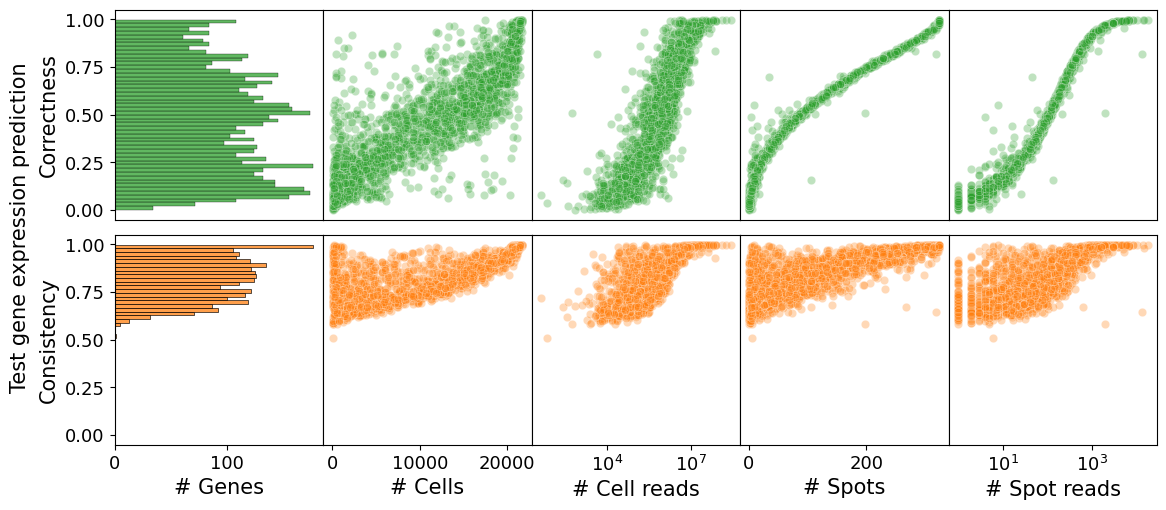

In [ ]:
import seaborn as sns

fig = plt.figure(figsize=(12, 4.5))

(topfig, bottomfig) = fig.subfigures(2, 1)
top_axs = topfig.subplots(1, 5)
bottom_axs = bottomfig.subplots(1, 5)

sns.histplot(
    data=df, 
    y="gene_expr_correct_cosine_sim", 
    bins=50, 
    ax=top_axs[0],
    color="tab:green",
)

sns.scatterplot(
    data=df,
    y="gene_expr_correct_cosine_sim",
    x="n_cells",
    ax=top_axs[1],
    alpha=0.3,
    color="tab:green",
)
#axs_f[2].set_title("score vs sparsity (spatial)")

sns.scatterplot(
    data=df,
    y="gene_expr_correct_cosine_sim",
    x="n_voxels",
    ax=top_axs[3],
    alpha=0.3,
    color="tab:green",
)
sns.scatterplot(
    data=df,
    y="gene_expr_correct_cosine_sim",
    x="cell_gene_counts",
    ax=top_axs[2],
    alpha=0.3,
    color="tab:green",
)
top_axs[2].set_xscale('log')
sns.scatterplot(
    data=df,
    y="gene_expr_correct_cosine_sim",
    x="voxel_gene_counts",
    ax=top_axs[4],
    alpha=0.3,
    color="tab:green",
)
top_axs[4].set_xscale('log')
top_axs[4].minorticks_off()

sns.histplot(
    data=df, 
    y="gene_expr_runs_corr", 
    bins=25, 
    ax=bottom_axs[0],
    color="tab:orange",
)
sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="n_cells",
    ax=bottom_axs[1],
    alpha=0.3,
    color="tab:orange",
)
sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="n_voxels",
    ax=bottom_axs[3],
    alpha=0.3,
    color="tab:orange",
)
sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="cell_gene_counts",
    ax=bottom_axs[2],
    alpha=0.3,
    color="tab:orange",
)
bottom_axs[2].set_xscale('log')
sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="voxel_gene_counts",
    ax=bottom_axs[4],
    alpha=0.3,
    color="tab:orange",
)
bottom_axs[4].set_xscale('log')
bottom_axs[4].minorticks_off()

top_axs[0].set_ylabel("Correctness", fontsize=15)
top_axs[0].set_xlabel("# Genes", fontsize=15)
top_axs[1].set_xlabel("# Cells", fontsize=15)
top_axs[3].set_xlabel("# Spots", fontsize=15)
top_axs[2].set_xlabel("# Cell reads", fontsize=15)
top_axs[4].set_xlabel("# Spot reads", fontsize=15)
bottom_axs[0].set_ylabel("Consistency", fontsize=15)
bottom_axs[0].set_xlabel("# Genes", fontsize=15)
bottom_axs[1].set_xlabel("# Cells", fontsize=15)
bottom_axs[3].set_xlabel("# Spots", fontsize=15)
bottom_axs[2].set_xlabel("# Cell reads", fontsize=15)
bottom_axs[4].set_xlabel("# Spot reads", fontsize=15)
for j in range(1,5):
    top_axs[j].set_ylabel("")
    top_axs[j].set_yticks([])
    bottom_axs[j].set_ylabel("")
    bottom_axs[j].set_yticks([])
for j in range(0,5):
    top_axs[j].set_xlabel("")
    top_axs[j].set_xticks([])
for i in range(0,5):
    top_axs[i].set_ylim([-0.05, 1.05])
    bottom_axs[i].set_ylim([-0.05, 1.05])
    top_axs[i].tick_params(axis='both', which='major', labelsize=13)
    bottom_axs[i].tick_params(axis='both', which='major', labelsize=13)

#topfig.patch.set_facecolor('blue')
topfig.patch.set_alpha(0.0)
bottomfig.patch.set_alpha(0.0)
fig.text(0.04, 0.5, 'Test gene expression prediction', 
         ha='center', va='center', rotation='vertical',
         fontdict={"fontsize":15}, zorder=0)

plt.tight_layout()
fig.subplots_adjust(wspace=0.0,hspace=0.0,)
#fig.text(0.04, 0.5, 'test gene expression prediction', ha='center', va='center', rotation='vertical',fontdict={"fontsize":24})
#fig.set_zorder(1)
#plt.savefig('poster_plots/training_genes_data_dependencies.png')
#plt.savefig('poster_plots/test_genes_data_dependencies.png',bbox_inches='tight',transparent=True, pad_inches=0.05)
plt.show()

##### train

In [ ]:
train_genes = np.load("visium_mouse_cortex_split/all_train_genes.npy", allow_pickle=True)
adata_sc_trainoverlap = adata_sc_overlap[:,train_genes].copy()
adata_sc_trainoverlap = adata_st_overlap[:,train_genes].copy()

In [ ]:
adata_sc_trainoverlap.var["gene_expr_correct_cosine_sim"] = np.array(metrics_train["gene_expr_cosine_sim"]["orig"]).mean(axis=0)
adata_sc_trainoverlap.var["gene_expr_runs_corr"] = np.array(metrics_train["g_gene_expr_corr"]["orig"])

In [ ]:
df = adata_sc_trainoverlap.var

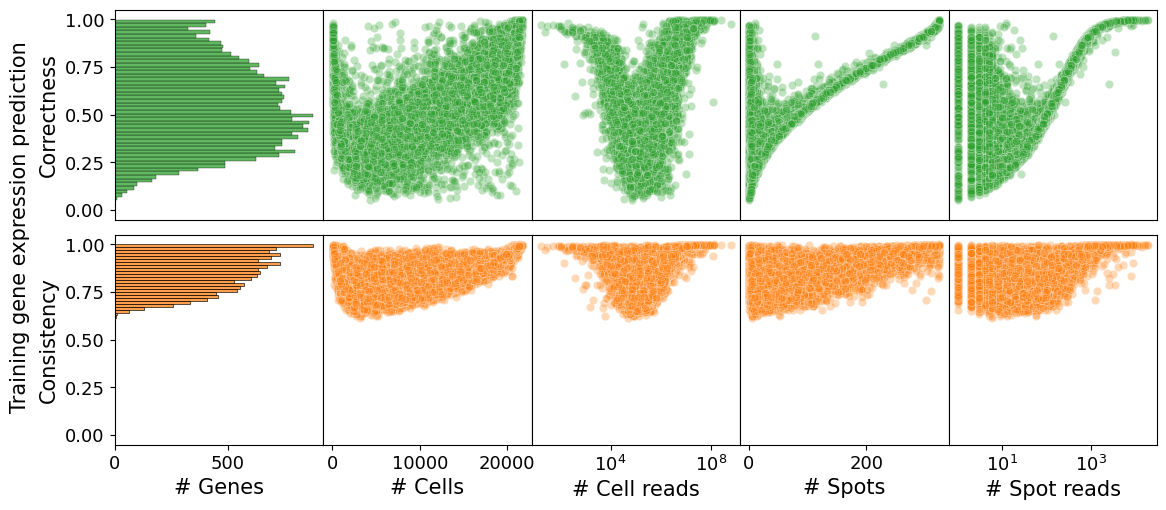

In [ ]:
import seaborn as sns

fig = plt.figure(figsize=(12, 4.5))

(topfig, bottomfig) = fig.subfigures(2, 1)

top_axs = topfig.subplots(1, 5)
bottom_axs = bottomfig.subplots(1, 5)

sns.histplot(
    data=df, 
    y="gene_expr_correct_cosine_sim", 
    bins=50, 
    ax=top_axs[0],
    color="tab:green",
)

sns.scatterplot(
    data=df,
    y="gene_expr_correct_cosine_sim",
    x="n_cells",
    ax=top_axs[1],
    alpha=0.3,
    color="tab:green",
)

sns.scatterplot(
    data=df,
    y="gene_expr_correct_cosine_sim",
    x="n_voxels",
    ax=top_axs[3],
    alpha=0.3,
    color="tab:green",
)
sns.scatterplot(
    data=df,
    y="gene_expr_correct_cosine_sim",
    x="cell_gene_counts",
    ax=top_axs[2],
    alpha=0.3,
    color="tab:green",
)
top_axs[2].set_xscale('log')
sns.scatterplot(
    data=df,
    y="gene_expr_correct_cosine_sim",
    x="voxel_gene_counts",
    ax=top_axs[4],
    alpha=0.3,
    color="tab:green",
)
top_axs[4].set_xscale('log')
top_axs[4].minorticks_off()

sns.histplot(
    data=df, 
    y="gene_expr_runs_corr", 
    bins=25, 
    ax=bottom_axs[0],
    color="tab:orange",
)
sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="n_cells",
    ax=bottom_axs[1],
    alpha=0.3,
    color="tab:orange",
)
sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="n_voxels",
    ax=bottom_axs[3],
    alpha=0.3,
    color="tab:orange",
)
sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="cell_gene_counts",
    ax=bottom_axs[2],
    alpha=0.3,
    color="tab:orange",
)
bottom_axs[2].set_xscale('log')
sns.scatterplot(
    data=df,
    y="gene_expr_runs_corr",
    x="voxel_gene_counts",
    ax=bottom_axs[4],
    alpha=0.3,
    color="tab:orange",
)
bottom_axs[4].set_xscale('log')
bottom_axs[4].minorticks_off()

top_axs[0].set_ylabel("Correctness", fontsize=15)
#top_axs[0].set_ylabel("$\mathbf{correctness}$\ngene expression\n cosine similarity")
top_axs[0].set_xlabel("# Genes", fontsize=15)
top_axs[1].set_xlabel("# Cells", fontsize=15)
top_axs[3].set_xlabel("# Spots", fontsize=15)
top_axs[2].set_xlabel("# Cell reads", fontsize=15)
top_axs[4].set_xlabel("# Spot reads", fontsize=15)
bottom_axs[0].set_ylabel("Consistency", fontsize=15)
bottom_axs[0].set_xlabel("# Genes", fontsize=15)
bottom_axs[1].set_xlabel("# Cells", fontsize=15)
bottom_axs[3].set_xlabel("# Spots", fontsize=15)
bottom_axs[2].set_xlabel("# Cell reads", fontsize=15)
bottom_axs[4].set_xlabel("# Spot reads", fontsize=15)
for j in range(1,5):
    top_axs[j].set_ylabel("")
    top_axs[j].set_yticks([])
    bottom_axs[j].set_ylabel("")
    bottom_axs[j].set_yticks([])
for j in range(0,5):
    top_axs[j].set_xlabel("")
    top_axs[j].set_xticks([])
    #bottom_axs[j].set_xlabel("")
    #bottom_axs[j].set_xticks([])
for i in range(0,5):
    top_axs[i].set_ylim([-0.05, 1.05])
    bottom_axs[i].set_ylim([-0.05, 1.05])
    top_axs[i].tick_params(axis='both', which='major', labelsize=13)
    bottom_axs[i].tick_params(axis='both', which='major', labelsize=13)

#topfig.patch.set_facecolor('blue')
topfig.patch.set_alpha(0.0)
bottomfig.patch.set_alpha(0.0)
fig.text(0.04, 0.5, 'Training gene expression prediction', 
         ha='center', va='center', rotation='vertical',
         fontdict={"fontsize":15}, zorder=0)

plt.tight_layout()
fig.subplots_adjust(wspace=0.0,hspace=0.0,)plt.show()